# ACA centroiding/ Dynamic Background/ Real Data Example#

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from astropy.io import ascii
from importlib import reload

In [2]:
# local imports:
import sys
sys.path.append("../py")
import classes
from classes import *
import sim_aca_l0 as siml0
import centroids as cntr
import myplot as mplt

### Example from gallery of centroid dashboard plots for lowering Kalman threshold###

See http://cxc.cfa.harvard.edu/mta/ASPECT/kalman_threshold/

Compute centroids using various algorithm <code>(FlightBgd, DynamBgd_Median, DynamBgd_SigmaClip)</code> for <code>obsID = 50274, slot = 6</code>.

__Results__

* Centroiding improves when dynamical background subtraction is applied to the data.

* Improvement is more significant in case of high number of pixel samples used to compute the dynamical background.

* This is due to starlight contamination of the dynamical background, and highlights again the importance of dealing properly with this issue.

In [3]:
std_results = """
name                 std_1000  std_5
FlightBgd            1.25      1.25
DynamBgd_Median      0.72      0.82
DynamBgd_SigmaClip   0.71      0.82
"""
std_results = ascii.read(std_results)
print(std_results)

       name        std_1000 std_5
------------------ -------- -----
         FlightBgd     1.25  1.25
   DynamBgd_Median     0.72  0.82
DynamBgd_SigmaClip     0.71  0.82


__Computations__

In [4]:
obsid = 50374
img_size = 8 # pixels
dwell = events.dwells.filter(obsid=obsid)[0]
slots = [6, 5] #faint, bright

In [5]:
msids = ["aoacfct{}".format(slot) for slot in range(8)]
msids = msids + ["aoacmag{}".format(slot) for slot in range(8)]

dat = fetch.MSIDset(msids, start=dwell.start, stop=dwell.stop)

print('TRAK:')
print([dat[msid].vals.tolist().count('TRAK') for msid in msids[:8]])
print('RACQ:')
print([dat[msid].vals.tolist().count('RACQ') for msid in msids[:8]])
print('SRCH:')
print([dat[msid].vals.tolist().count('SRCH') for msid in msids[:8]])
print('MAG:')
print([np.median(dat[msid].vals) for msid in msids[8:]])

TRAK:
[6958, 6850, 6966, 6966, 6960, 6850, 6960, 6966]
RACQ:
[0, 108, 0, 0, 6, 108, 6, 0]
SRCH:
[8, 8, 0, 0, 0, 8, 0, 0]
MAG:
[10.625, 10.375, 7.625, 8.75, 8.4375, 7.125, 10.0, 10.0]


In [6]:
def do_computations(slots, dwell, img_size, nframes, bgd_kwargs):
    rows_all = []
    for slot in slots:
        slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
        for i, Bgd_Class in enumerate([FlightBgd, DynamBgd_Median, DynamBgd_SigmaClip]):
            bgd_object = Bgd_Class(**bgd_kwargs[i])
            #print(bgd_object.__class__.__name__)
            rows = cntr.centroids(slot, slot_data, img_size, bgd_object, nframes=nframes)
            for row in rows:
                row['mag'] = np.median(dat["aoacmag{}".format(slot)].vals)
                row['bgd_class_name'] = bgd_object.__class__.__name__
                if isinstance(bgd_object, (DynamBgd_Median, DynamBgd_SigmaClip)):
                    row['ndeque'] = bgd_kwargs[i]['ndeque']
                else:
                    row['ndeque'] = None
                rows_all.append(row)        
    t = Table(rows_all)
    return t

In [7]:
bgdavg = None
nframes = 1000 # delta_t = 2.05 sec, so use 1000 frames for ~2 dither periods

In [8]:
ndeque = 1000
bgd_kwargs = [{}, {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque},
                  {'img_size':img_size, 'bgdavg':bgdavg, 'ndeque':ndeque}]

__Large__ number of stored pixel values

In [9]:
ndeque = 1000
bgd_kwargs[1]['ndeque'] = ndeque
bgd_kwargs[2]['ndeque'] = ndeque

In [10]:
t_data_1000 = do_computations(slots, dwell, img_size, nframes=nframes, bgd_kwargs=bgd_kwargs)

__Small__ number of stored pixel values

In [11]:
ndeque = 5
bgd_kwargs[1]['ndeque'] = ndeque
bgd_kwargs[2]['ndeque'] = ndeque

In [12]:
t_data_5 = do_computations(slots, dwell, img_size, nframes=nframes, bgd_kwargs=bgd_kwargs)

### Plot residuals###

In [13]:
ok = t_data_1000['bgd_class_name'] == 'FlightBgd'
print((t_data_1000['time'][ok][1] - t_data_1000['time'][ok][0])[:5]) # bright - faint

[ 0.  0.  0.  0.  0.]


Slot 6 - Slot 5
ndeque = 1000


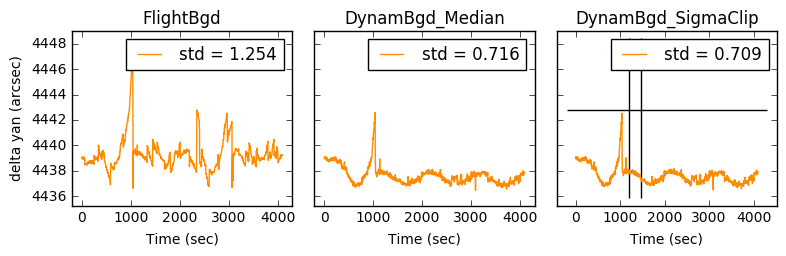

In [14]:
reload(mplt)
dt = 0. # shift in sec between time axes for faint and bright star
key = 'yan'
mplt.plot_d_ang(6, 5, key, dt, t_data_1000)
print("Slot 6 - Slot 5")
print("ndeque = 1000")
plt.vlines([1200, 1470], plt.ylim()[0], plt.ylim()[1]);
plt.hlines([4442.8], plt.xlim()[0], plt.xlim()[1]);

Slot 6 - Slot 5
ndeque = 5


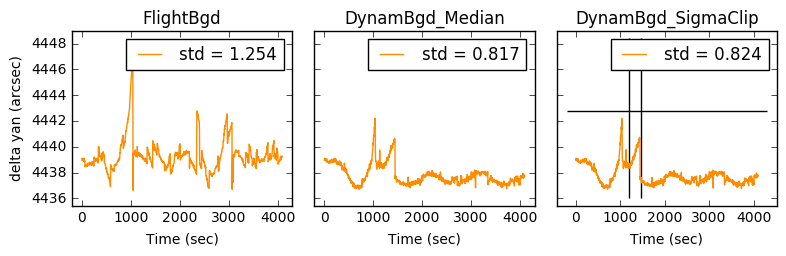

In [15]:
dt = 0. # shift in sec between time axes for faint and bright star
key = 'yan'
mplt.plot_d_ang(6, 5, key, dt, t_data_5)
print("Slot 6 - Slot 5")
print("ndeque = 5")
plt.vlines([1200, 1470], plt.ylim()[0], plt.ylim()[1]);
plt.hlines([4442.8], plt.xlim()[0], plt.xlim()[1]);

### Plot centroids###


Large number of samples, ndeque = 1000


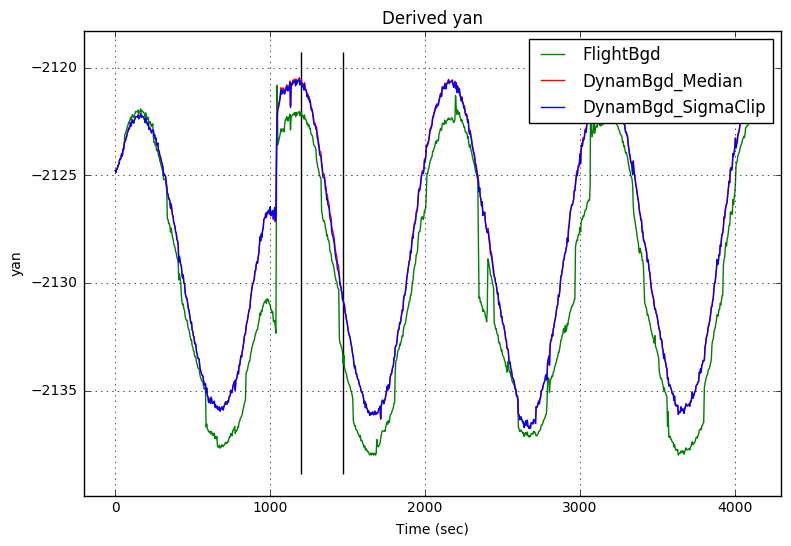

In [16]:
slot = slots[0] # 6, Faint star
#mplt.plot_coords(slot, t_data_1000, 'row') # computed 'row' coordinate (between 0 and 8)
mplt.plot_coords(slot, t_data_1000, 'yan') # computed 'yan' coordinate
print()
print("Large number of samples, ndeque = {}".format(1000))
plt.vlines([1200, 1470], plt.ylim()[0], plt.ylim()[1]);


Small number of samples, ndeque = 5


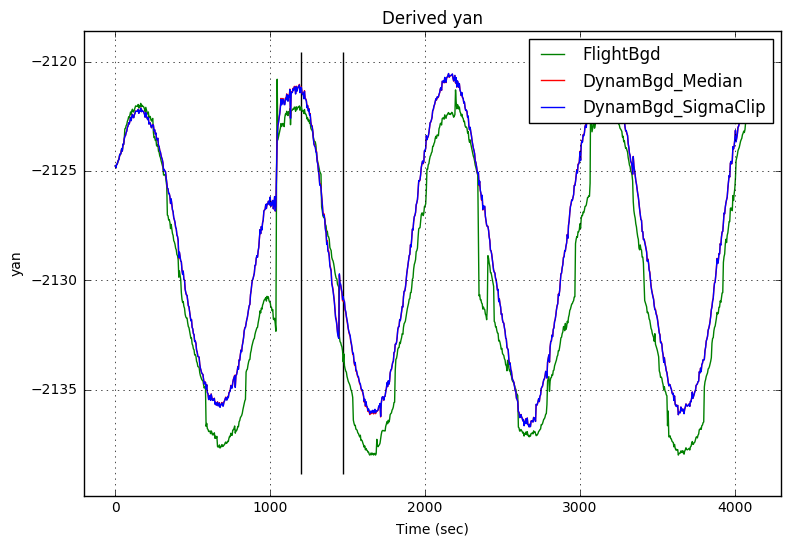

In [17]:
slot = slots[0] # 6, Faint star
#mplt.plot_coords(slot, t_data_5, 'row') # computed 'row' coordinate (between 0 and 8)
mplt.plot_coords(slot, t_data_5, 'yan') # computed 'yan' coordinate
print()
print("Small number of samples, ndeque = {}".format(5))
plt.vlines([1200, 1470], plt.ylim()[0], plt.ylim()[1]);

### Plot derived background and star images, and hot pixels time history ###

* <span style="color:black;font-weight:bold">Black patch</span> - CCD region that will eventually be sampled due to the dither
* <span style="color:crimson;font-weight:bold">6x6 patches</span> - pixel region corresponding to background derived for a current frame (sampled edge pixels + average background value for pixels inside the edge)

In [18]:
slot = slots[0] # 6

__Time around t=1000 sec, the most pronounced peak in the centroid residuals:__
* Between <code>t=770 sec</code> and <code>t=870 sec</code> star is close to the cluster of at least two hot pixels in the upper left corner. The location of these hot pixels is such that they are used in centroids calculations.

* One of these hot pixels is flickering <code>(436, -187)</code>, the other <code>(436, -188)</code> appears static on the timescale of this observation.

Format of the titles is 'time: imgrow0, imgcol0'
Plot imgraw from 185 to 213
Bgd Class: DynamBgd_Median, ndeque = 5


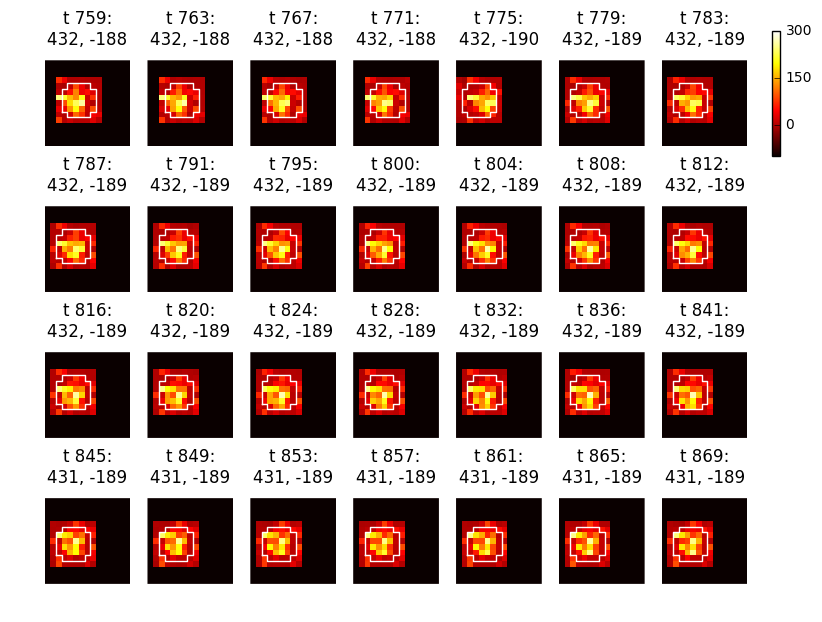

In [19]:
data = mplt.plot_images(t_data_5, n_start=185, n_stop=213, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, vmax=300, colname='imgraw')

ndeque = 5


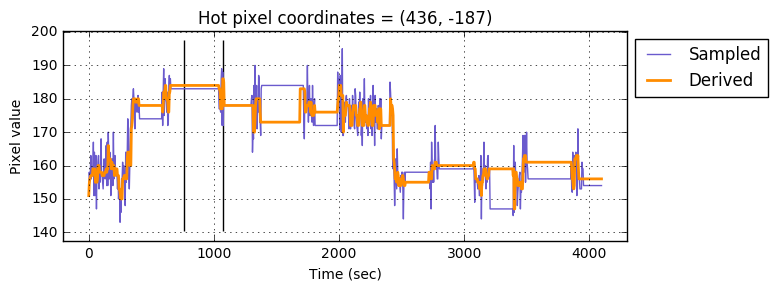

In [20]:
mplt.plot_px_history(t_data_5, [(436, -187)], slot=6, bgd_class_name='DynamBgd_Median')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));
print("ndeque = 5")
plt.vlines([760, 1070], plt.ylim()[0], plt.ylim()[1]);
#plt.vlines([1200, 1386, 1470], plt.ylim()[0], plt.ylim()[1]);

ndeque = 5


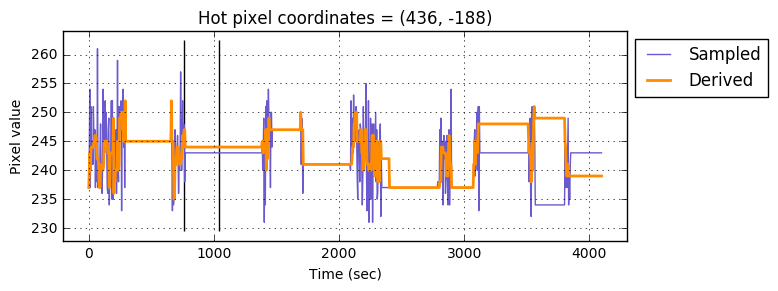

In [21]:
mplt.plot_px_history(t_data_5, [(436, -188)], slot=6, bgd_class_name='DynamBgd_Median')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));
print("ndeque = 5")
plt.vlines([760, 1037], plt.ylim()[0], plt.ylim()[1]);

* Dynamic background algorithm ensures that these two hot pixels are included in background subtraction (see the raw, bgd, and bgd subtracted images below).

* Centroiding improves for time around <code>t=1000 sec</code>.

* Between <code>t=870 sec and 1037 sec</code>, star drifts toward the lower right corner, the ACA image windows gets adjusted.

* The static hot pixel lands outside of the 8x8 image window, and the flickering hot pixel lands on the edge and is sampled as background.

* Note that between <code>t = 1017 sec</code> and <code>t = 1037 sec</code> starlight is sampled as background, and it is visible in bgd images for <code>t > 1040 sec</code>.

Format of the titles is 'time: imgrow0, imgcol0'
Plot imgraw from 241 to 262
Bgd Class: DynamBgd_Median, ndeque = 5


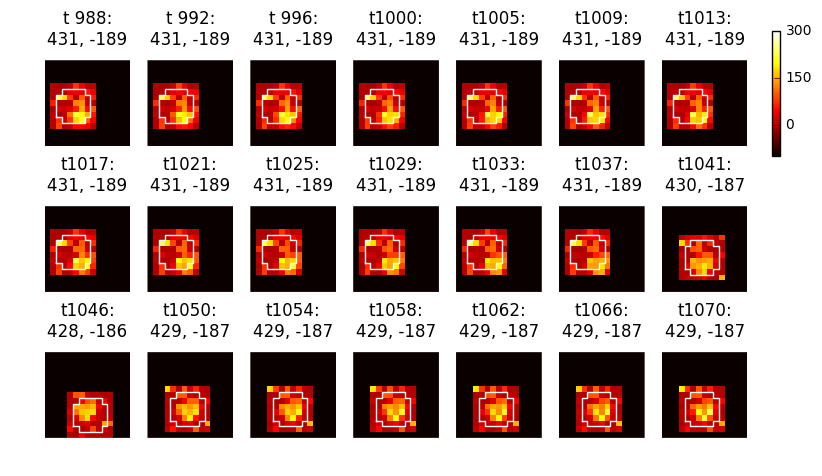

In [22]:
data = mplt.plot_images(t_data_5, n_start=241, n_stop=262, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, vmax=300, colname='imgraw')

Format of the titles is 'time: imgrow0, imgcol0'
Plot bgdimg from 241 to 262
Bgd Class: DynamBgd_Median, ndeque = 5


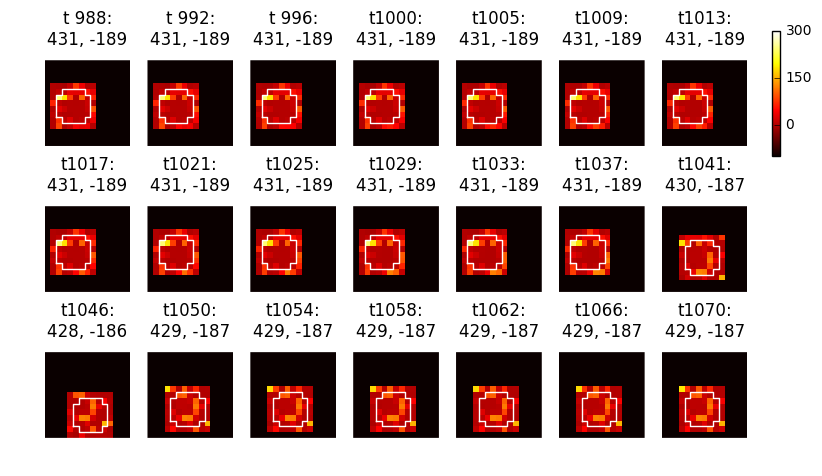

In [23]:
data = mplt.plot_images(t_data_5, n_start=241, n_stop=262, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, vmax=300, colname='bgdimg')

Format of the titles is 'time: imgrow0, imgcol0'
Plot img from 241 to 262
Bgd Class: DynamBgd_Median, ndeque = 5


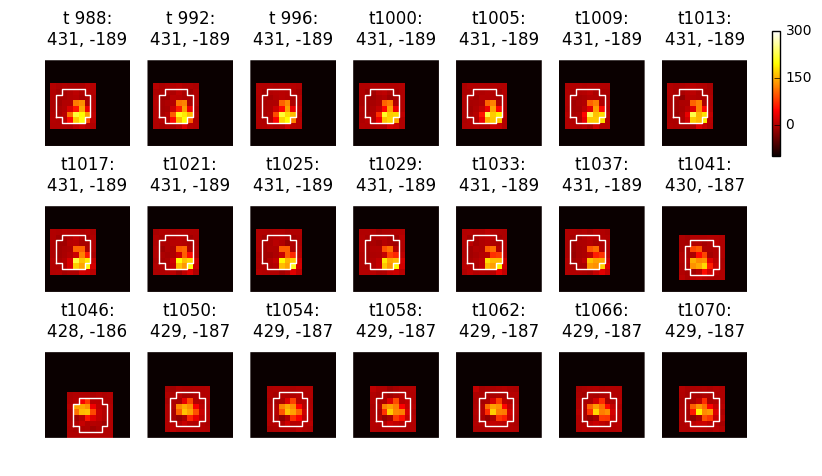

In [24]:
data = mplt.plot_images(t_data_5, n_start=241, n_stop=262, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, vmax=300, colname='img')

* Starlight presence is more significant in the background computed with few pixel value samples because sampling using high number of pixel values underestimates the value of these starlight contaminated pixels.

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 241 to 262
Bgd Class: DynamBgd_Median, ndeque = 5


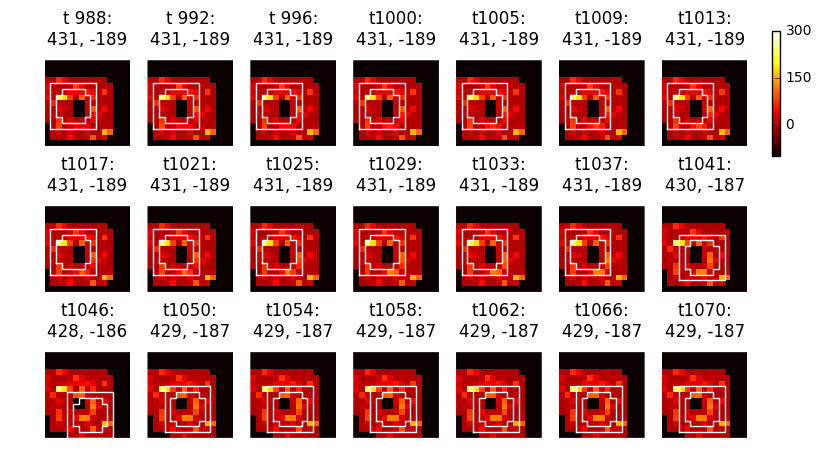

In [25]:
data = mplt.plot_bgd_patches(t_data_5, n_start=241, n_stop=262, slot=slot,
                             img_size=img_size, bgd_class_name='DynamBgd_Median',
                             vmin=-100, vmax=300)

Format of the titles is 'time: imgrow0, imgcol0'
Plot frames from 241 to 262
Bgd Class: DynamBgd_Median, ndeque = 1000


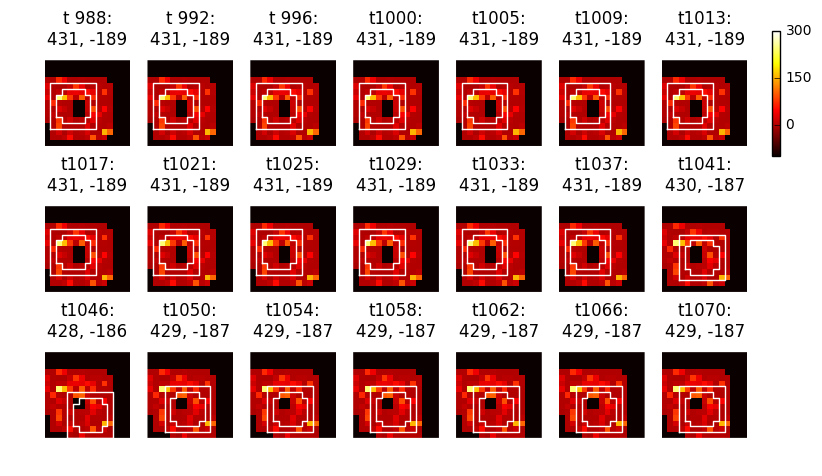

In [26]:
data = mplt.plot_bgd_patches(t_data_1000, n_start=241, n_stop=262, slot=slot,
                             img_size=img_size, bgd_class_name='DynamBgd_Median',
                             vmin=-100, vmax=300)

* The peak at <code>t = 1000 sec</code> seems to be accounted for better in the case of few pixel value samples (see the horizontal line in the centroid residuals plot).

* This is consistent with the simulations: the flickering hot pixel is incorporated into background subtraction with more fidelity if the dynamical background algorithm uses few latest pixel value samples.

ndeque = 1000


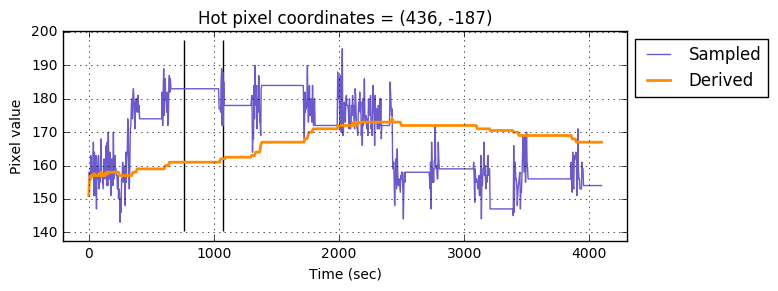

In [27]:
mplt.plot_px_history(t_data_1000, [(436, -187)], slot=6, bgd_class_name='DynamBgd_Median')
print("ndeque = 1000")
plt.vlines([760, 1070], plt.ylim()[0], plt.ylim()[1]);
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));

__Residual feature at <cide>t=1200-1470 sec<code>:__
* Centroid residuals for dynamical background with low number of pixel values show a feature between <code>t=1200 sec</code> and <code>t=1470 sec</code> that is visible neither in the FlightBgd case nor DynamBgd with high number of pixel values.

* This feature is due to background contamination due to starlight. Again, DynamBgd with high number of pixel values underestimates the value of these starlight contaminated bgd pixels, and centroiding does not deteriorate.

* This is illustrated below with raw, bgd, and bgd subtracted images corresponding to a set of initial and final time frames corresponding to the time period when the feature appears. Bgd subtracted images for <code>ndeque=5</code> and <code>ndeque=1000</code> are compared (see cells 30 and 31, and 34 and 35).

* This highlights the importance of developing an algorithm able to deal properly with starlight contamination and use a small number of stored pixel values.

* Time history of two example star contaminated bgd pixels shows a gradualy rising profile. This is characteristic to an increasing contribution from a star drifting toward this pixel, rather than to a flickering pixel phenomenon.

Format of the titles is 'time: imgrow0, imgcol0'
Plot imgraw from 293 to 300
Bgd Class: DynamBgd_Median, ndeque = 5


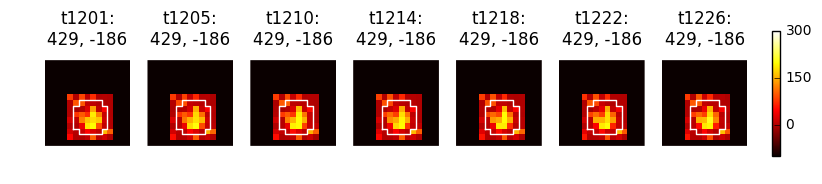

In [28]:
data = mplt.plot_images(t_data_5, n_start=293, n_stop=300, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, vmax=300, colname='imgraw')

Format of the titles is 'time: imgrow0, imgcol0'
Plot bgdimg from 293 to 300
Bgd Class: DynamBgd_Median, ndeque = 5


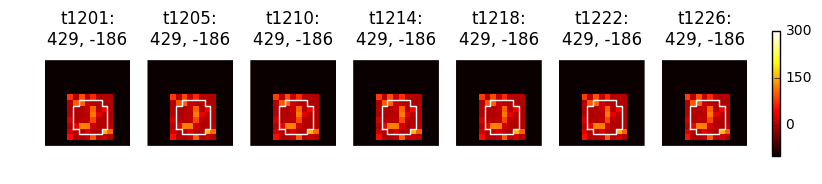

In [29]:
data = mplt.plot_images(t_data_5, n_start=293, n_stop=300, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, vmax=300, colname='bgdimg')

Format of the titles is 'time: imgrow0, imgcol0'
Plot img from 293 to 300
Bgd Class: DynamBgd_Median, ndeque = 5


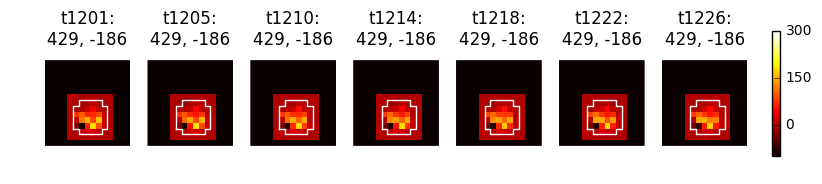

In [30]:
data = mplt.plot_images(t_data_5, n_start=293, n_stop=300, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, vmax=300, colname='img')

Format of the titles is 'time: imgrow0, imgcol0'
Plot img from 293 to 300
Bgd Class: DynamBgd_Median, ndeque = 1000


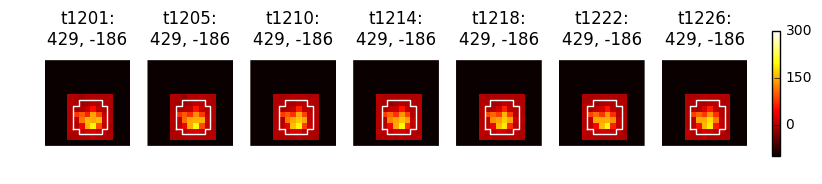

In [31]:
data = mplt.plot_images(t_data_1000, n_start=293, n_stop=300, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, vmax=300, colname='img')

Format of the titles is 'time: imgrow0, imgcol0'
Plot imgraw from 353 to 360
Bgd Class: DynamBgd_Median, ndeque = 5


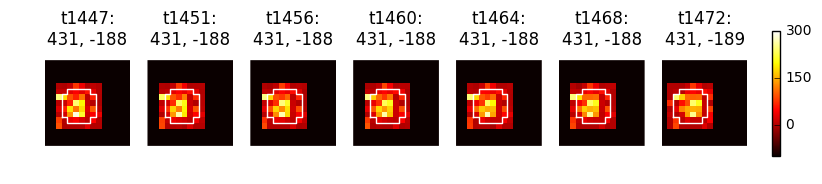

In [32]:
data = mplt.plot_images(t_data_5, n_start=353, n_stop=360, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, vmax=300, colname='imgraw')

Format of the titles is 'time: imgrow0, imgcol0'
Plot bgdimg from 353 to 360
Bgd Class: DynamBgd_Median, ndeque = 5


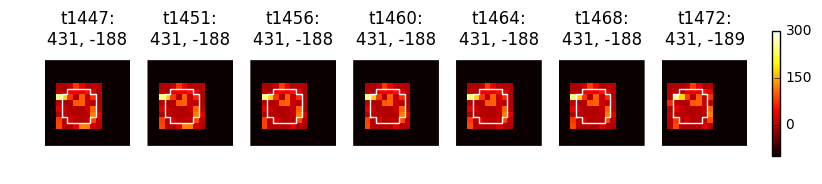

In [33]:
data = mplt.plot_images(t_data_5, n_start=353, n_stop=360, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, vmax=300, colname='bgdimg')

Format of the titles is 'time: imgrow0, imgcol0'
Plot img from 353 to 360
Bgd Class: DynamBgd_Median, ndeque = 5


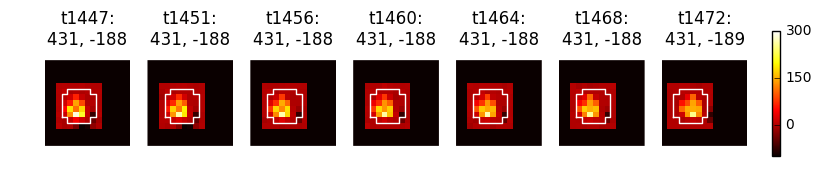

In [34]:
data = mplt.plot_images(t_data_5, n_start=353, n_stop=360, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, vmax=300, colname='img')

Format of the titles is 'time: imgrow0, imgcol0'
Plot img from 353 to 360
Bgd Class: DynamBgd_Median, ndeque = 1000


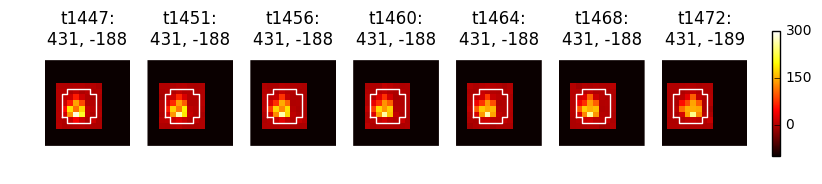

In [35]:
data = mplt.plot_images(t_data_1000, n_start=353, n_stop=360, slot=slot,
                        img_size=img_size, bgd_class_name='DynamBgd_Median',
                        vmin=-100, vmax=300, colname='img')

ndeque = 5


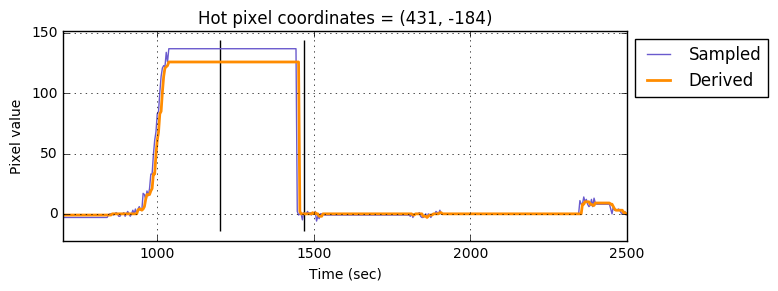

In [36]:
mplt.plot_px_history(t_data_5, [(431, -184)], slot=6, bgd_class_name='DynamBgd_Median')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));
print("ndeque = 5")
plt.vlines([1200, 1470], plt.ylim()[0], plt.ylim()[1]);
plt.xlim(700, 2500);

ndeque = 5


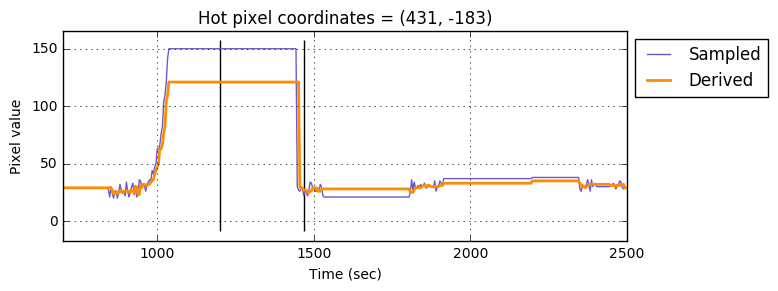

In [37]:
mplt.plot_px_history(t_data_5, [(431, -183)], slot=6, bgd_class_name='DynamBgd_Median')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));
print("ndeque = 5")
plt.vlines([1200, 1470], plt.ylim()[0], plt.ylim()[1]);
plt.xlim(700, 2500);

ndeque = 1000


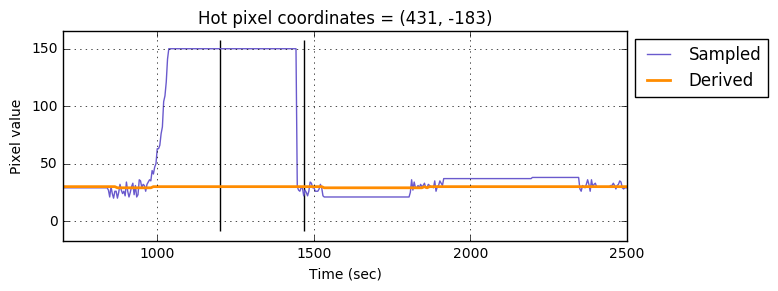

In [38]:
mplt.plot_px_history(t_data_1000, [(431, -183)], slot=6, bgd_class_name='DynamBgd_Median')
plt.legend(loc=2, bbox_to_anchor=(1.0, 1.0));
print("ndeque = 1000")
plt.vlines([1200, 1470], plt.ylim()[0], plt.ylim()[1]);
plt.xlim(700, 2500);